In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
# avoid warnings
import warnings
warnings.filterwarnings('ignore')

# Read and Preprocess the data

In [40]:
# Load dataset
data = pd.read_csv('tested.csv')

In [42]:
# See info data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [43]:
# See null columns
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [44]:
# Preprocessing
# Handle missing values
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Fare'].fillna(data['Fare'].median(), inplace=True)

# Drop columns irrelevant information
data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1, inplace=True)

In [45]:
# Encode categorical variables
data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)

# Define features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train the models (Logistic Regresion and Random Forest)

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Create models
lr = LogisticRegression()
rf = RandomForestClassifier()

# Train models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Evaluate models
from sklearn.metrics import accuracy_score

print("Accuracy Logistic Regression: ", accuracy_score(y_test, y_pred_lr))
print("Accuracy Random Forest: ", accuracy_score(y_test, y_pred_rf))

Accuracy Logistic Regression:  1.0
Accuracy Random Forest:  1.0


`Interpretacion`:
Al entrenar los modelos se obtienen precisiones del 100% en ambos, lo que puede sugerir muchas cosas, entre ellas que la data se muy representativa, o en nuestro caso lo mas probable, que la data sea muy poca, ya que contamos solo con 480 registros. Por ello se realizara la optimizacion de hiperparametros para obtener un resultado optimo.

# Optimization with Optuna

## Optimization for LogisticRegression

In [72]:
# Optimize hyperparameters for Logistic Regression using Optuna
import optuna
from sklearn.metrics import accuracy_score
from optuna.visualization import plot_optimization_history, plot_param_importances

def objective_lr(trial):
    # Define los hiperparámetros a optimizar
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l2'])
    max_iter = trial.suggest_int('max_iter', 50, 1000, step=100)
    
    # Crea el modelo con los hiperparámetros dados
    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter, penalty=penalty)
    
    # Entrena el modelo
    model.fit(X_train, y_train)
    
    # Predicción y cálculo de precisión
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

# Crea un estudio para Regresión Logística
study_lr = optuna.create_study(direction='maximize', study_name='Logistic Regression')
study_lr.optimize(objective_lr, n_trials=250) # type: ignore

[I 2024-11-26 16:14:28,497] A new study created in memory with name: Logistic Regression
[I 2024-11-26 16:14:28,506] Trial 0 finished with value: 1.0 and parameters: {'C': 30.72141975844997, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 450}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:14:28,518] Trial 1 finished with value: 0.6507936507936508 and parameters: {'C': 0.0035985544509243806, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 50}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:14:28,552] Trial 2 finished with value: 0.7222222222222222 and parameters: {'C': 0.3274030208169327, 'solver': 'sag', 'penalty': 'l2', 'max_iter': 950}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:14:28,567] Trial 3 finished with value: 1.0 and parameters: {'C': 7.362443597864367, 'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 550}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:14:28,579] Trial 4 finished with value: 0.6666666666666666 and parameters: {'C': 0.136546878940225

In [73]:
# Visualizar historial de optimización
fig_lr = plot_optimization_history(study_lr)
fig_lr.show()

# Visualizar importancia de hiperparámetros
fig_lr_param = plot_param_importances(study_lr)
fig_lr_param.show()

`Interpretacion:` 
1. **Historial de Optimización**
Esta estabilidad del valor objetivo en las iteraciones finales indica que el espacio de búsqueda de hiperparámetros estaba bien definido y permitió encontrar una solución efectiva con rapidez. Sin embargo, también sugiere que podría no ser necesario realizar tantas iteraciones en futuras optimizaciones, lo que ahorraría tiempo computacional.

1. **Importancia de los Hiperparámetros**
La gráfica de importancia de los hiperparámetros revela que el parámetro solver es, con diferencia, el más influyente en el desempeño del modelo, con una importancia del 94%. Esto significa que el método de optimización seleccionado para entrenar el modelo tiene un impacto crítico en su capacidad para clasificar correctamente los datos. Por otro lado, los hiperparámetros max_iter y C presentan una importancia significativamente menor, de apenas 3% cada uno, lo cual sugiere que el modelo no es particularmente sensible a estos valores en el rango probado durante la optimización.

Estos resultados destacan la necesidad de enfocar los esfuerzos de ajuste en el solver para maximizar el desempeño del modelo. Sin embargo, es importante no descartar completamente los otros hiperparámetros, ya que pueden tener un impacto más significativo en contextos o datasets diferentes. Además, se recomienda revisar si las opciones probadas para solver abarcan toda la variedad de métodos aplicables a este problema específico, ya que podría haber alternativas aún más eficaces.

## Optimization for Random Forest

In [111]:
# Optimize hyperparameters for Random Forest using Optuna
def objective_rf(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int("n_estimators", 1, 15)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    min_samples_split = trial.suggest_int("min_samples_split", 3, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    criterion = trial.suggest_categorical("criterion", ["entropy", "log_loss"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"])

    # Crear el modelo con los hiperparámetros dados
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
        criterion=criterion,
        class_weight=class_weight
    )

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Predicción y cálculo de precisión
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy


# Crea un estudio para Bosque Aleatorio
study_rf = optuna.create_study(direction="maximize", study_name="Random Forest")
study_rf.optimize(objective_rf, n_trials=100)

[I 2024-11-26 16:25:35,440] A new study created in memory with name: Random Forest
[I 2024-11-26 16:25:35,458] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 6, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 6, 'bootstrap': False, 'criterion': 'log_loss', 'class_weight': 'balanced'}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:25:35,473] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 4, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:25:35,493] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 12, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 6, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:25:35,520] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 

In [112]:
# Visualizar historial de optimización
fig_rf = plot_optimization_history(study_rf)
fig_rf.show()

# Visualizar importancia de hiperparámetros
fig_rf_param = plot_param_importances(study_rf)
fig_rf_param.show()


`Interpretacion`:
1. **Historial de Optimización**
El modelo de Random Forest ha demostrado un desempeño consistentemente alto en la optimización, logrando en la mayoría de los casos el mejor valor posible. Este rendimiento sugiere que el conjunto de datos utilizado es bien separado o fácilmente clasificable, lo cual podría indicar un buen diseño del dataset o características altamente predictivas.

1. **Importancia de los Hiperparámetros**
A lo largo de las iteraciones, se han probado diferentes combinaciones de hiperparámetros, incluyendo el número de árboles (n_estimators), la profundidad máxima del árbol (max_depth), y criterios relacionados con el tamaño mínimo de división de nodos. El hecho de que múltiples configuraciones den como resultado el máximo rendimiento sugiere que el modelo tiene cierta robustez a los cambios de configuración, lo cual es positivo para su aplicabilidad en otros contextos.
Aunque en algunos casos el rendimiento es ligeramente inferior, como en los valores menores a 1.0, estos resultados están relacionados con configuraciones extremas, como un número muy bajo de árboles o profundidades no óptimas. Esto reafirma la importancia del hiperparametro `n_estimators` con un 88%.

En términos prácticos, los resultados indican que las características del dataset permiten la construcción de modelos altamente efectivos. No obstante, sería prudente evaluar la generalización del modelo en un conjunto de pruebas independiente para confirmar que los resultados no están influidos por una alta dependencia de los datos de entrenamiento. Además, evaluar métricas adicionales como la precisión, sensibilidad y especificidad podría proporcionar una visión más integral del comportamiento del modelo.

## Comparacion de resultados

Logistic Regression:
Best Accuracy: 1.0
Best Params: {'C': 30.72141975844997, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 450}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00        49

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



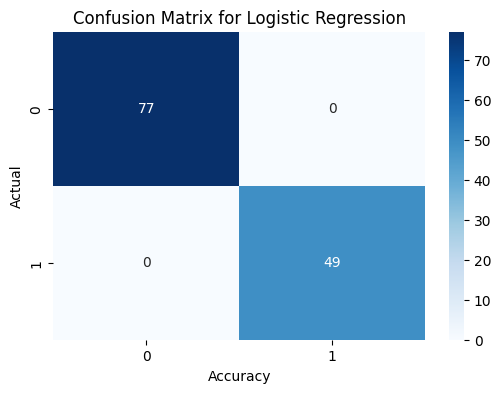

Random Forest:
Best Accuracy: 1.0
Best Params: {'n_estimators': 6, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 6, 'bootstrap': False, 'criterion': 'log_loss', 'class_weight': 'balanced'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00        49

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



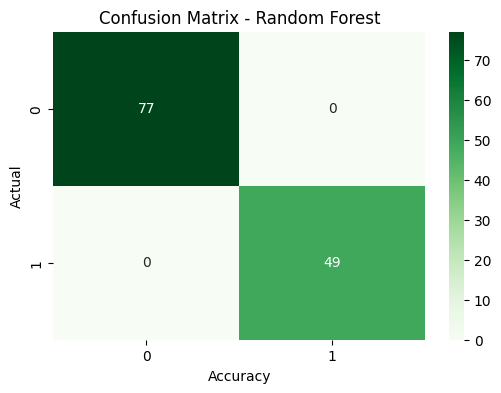

In [113]:
# Matriz de confusión para Regresión Logística
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Entrenar y evaluar el mejor modelo de Regresión Logística
best_lr = LogisticRegression(**study_lr.best_params)
best_lr.fit(X_train, y_train)
lr_preds = best_lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_preds)

print("Logistic Regression:")
print(f"Best Accuracy: {lr_accuracy}")
print("Best Params:", study_lr.best_params)
print(classification_report(y_test, lr_preds))


cm_lr = confusion_matrix(y_test, lr_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Accuracy')
plt.ylabel('Actual')
plt.show()

# Train and evaluate the best Random Forest model
best_rf = RandomForestClassifier(**study_rf.best_params)
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Random Forest:")
print(f"Best Accuracy: {rf_accuracy}")
print("Best Params:", study_rf.best_params)
print(classification_report(y_test, rf_preds))

# Matriz de confusión para Bosque Aleatorio
cm_rf = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Accuracy')
plt.ylabel('Actual')
plt.show()

`Interpretacion`:
Como podemos observar tanto con las metricas de recall, precision y f1-score, ambos modelos obtienen altos valores indicando que son buenos modelos para clasificar los datos. Por lo que para la seleccion del modelo a utilizar se debe de considerar otros factores como el costo computacional.

## Model Selection

In [114]:
# Select the model with less computational cost (logistic regresion)
best_model = best_lr
# Retrain the best model on the entire dataset
best_model.fit(X, y)

# Evaluate the model 
preds = best_model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
# classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00        49

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



`Interpretacion:`
Debido a que ambos modelos obtuvieron 100% de precision tras la optimizacion de hiperparametros, el criterio de eleccion sera en base al costo computacional de estos, ya que tendra que ser desplegado. Por lo que se selecciono `Logistic Regression`, ya que es un modelo lineal con una complejidad significativamente menor tanto en el entrenamiento como en la predicción. Mientras que `Logistic Regression` optimiza coeficientes en un espacio convex, `Random Forest` requiere construir y evaluar múltiples árboles de decisión, lo que implica mayor uso de memoria y tiempo de cómputo, especialmente con datos grandes. Dado que ambos modelos obtienen un 100% de precisión en este caso, optar por Logistic Regression es más práctico y escalable, al ofrecer el mismo desempeño con un menor costo computacional.

## Export the Model

In [115]:
# save model
import joblib
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']